In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import itertools
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
params = {'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large',
         'figure.figsize': (12,5), "axes.labelsize":'x-large'}
plt.rcParams.update(params)

In [29]:
data = pd.read_pickle('res_race.p')
print(len(data))

822


In [30]:
data['sample_size'] = data.g1t + data.g2t
data = data.rename(columns={'imbal':'imbalance'})
data.head()

,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbalance,ngrps,g1t,g2t,g1counts,g2counts,grouplabels,sample_size
NCT00000392,0.237493,77.0,66.0,0.263249,0.406202,0.101003,3,104,108,"[5.0, 16.0, 83.0]","[5.0, 9.0, 94.0]","[Black, Hispanic, White]",212
NCT00004732,0.014136,1240.0,1262.0,28.170907,28.419711,0.009706,3,1262,1240,"[81.0, 9.0, 1172.0]","[71.0, 9.0, 1160.0]","[Non-White, Not Specified, White]",2502
NCT00053846,0.124274,192.0,187.0,2.620000,2.850000,0.006725,3,187,192,"[19.0, 2.0, 166.0]","[20.0, 1.0, 171.0]","[African American, Other, White]",379
NCT00065507,0.548554,73.0,76.0,2.178721,1.743560,0.065870,4,100,91,"[55.0, 5.0, 5.0, 35.0]","[49.0, 5.0, 9.0, 28.0]","[Asian, Black/African American, Other, White]",191
NCT00067470,0.597447,19.0,19.0,122.000000,154.000000,0.408633,6,19,20,"[1.0, 1.0, 1.0, 1.0, 0.0, 15.0]","[1.0, 2.0, 3.0, 1.0, 4.0, 9.0]","[Asian, Black, Hispanic, Indigenous, Other, Wh...",39


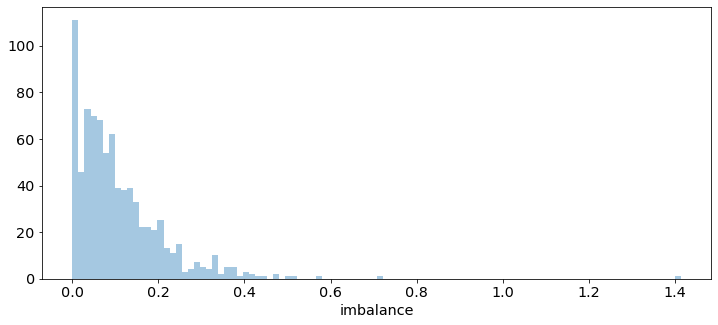

In [31]:
sns.distplot(data['imbalance'], kde=False, bins=100)

In [32]:
data.imbalance.describe(np.arange(0, 1, 0.05))

count    822.000000
mean       0.107451
std        0.106742
min        0.000000
0%         0.000000
5%         0.000000
10%        0.000020
15%        0.019261
20%        0.030404
25%        0.037429
30%        0.045651
35%        0.054537
40%        0.062381
45%        0.070711
50%        0.080014
55%        0.092464
60%        0.101681
65%        0.117852
70%        0.131800
75%        0.146972
80%        0.171002
85%        0.197831
90%        0.231369
95%        0.307835
max        1.414214
Name: imbalance, dtype: float64

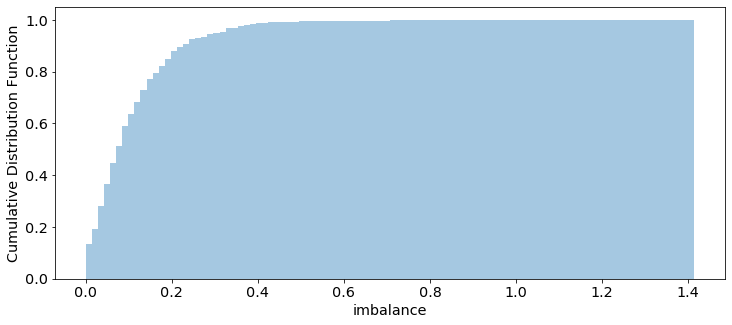

In [33]:
sns.distplot(
    data['imbalance'], kde=False, hist_kws={'cumulative': True}, norm_hist=True,
    bins=100
)
plt.ylabel('Cumulative Distribution Function')
plt.show()

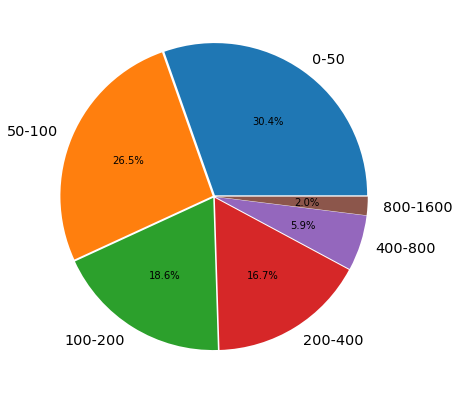

In [34]:
# trial size distribution
labels = []
shares = []

sample_sizes = [0, 50, 100, 200, 400, 800, 1600]
for i in range(len(sample_sizes)-1):
    lower, upper = sample_sizes[i:i+2]
    shares.append(
        data.sample_size.between(lower, upper).mean().round(2))
    labels.append('{}-{}'.format(lower, upper))    
    
plt.figure(figsize=(7, 7))
plt.pie(shares, explode=[.01] * len(shares), labels=labels, autopct='%.1f%%')
plt.show()

In [35]:
data.sample_size.describe()

count       822.000000
mean        305.189781
std        3610.691925
min          21.000000
25%          43.000000
50%          80.000000
75%         200.000000
max      103048.000000
Name: sample_size, dtype: float64

In [36]:
# ensure treatment and control groups are of similar sizes?
data = data.loc[np.log(data.g1t/data.g2t).abs() <= np.log(3)]
print(data.shape)

(817, 13)


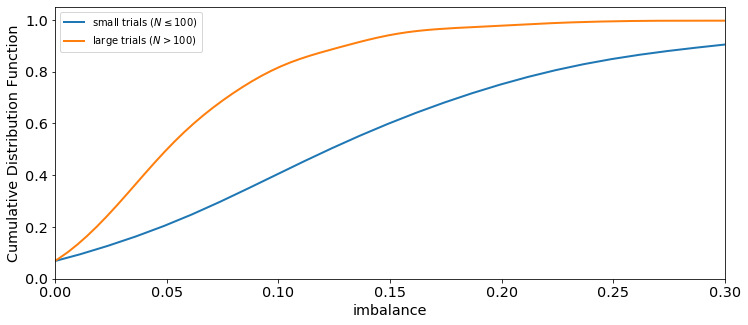

In [37]:
sns.distplot(
    data['imbalance'].loc[data.sample_size.between(0,100)], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": "small trials $(N \leq 100)$"}, 
    norm_hist=True, 
    bins=100
)
sns.distplot(
    data['imbalance'].loc[data.sample_size > 100], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": 'large trials $(N > 100)$'}, 
    norm_hist=True,
    bins=100
)
plt.xlim(0, .3)
plt.ylabel('Cumulative Distribution Function')
plt.show()

### Relative Imbalance was skipped, potentially it can be implementable if we look through the multi buckets

In [38]:
# additional variables

def average_sd(x):
    g1t, g2t, g1_sd_sample, g2_sd_sample = x
    return np.sqrt(g1t * g1_sd_sample **2 + g2t * g2_sd_sample ** 2) / np.sqrt(g1t + g2t)
    
data['average_sd'] = data[['g1t', 'g2t', 'g1_sd_sample', 'g2_sd_sample']].apply(
    average_sd, axis=1
)
data.head().T

,NCT00000392,NCT00004732,NCT00053846,NCT00065507,NCT00067470
effect,0.237493,0.0141359,0.124274,0.548554,0.597447
g1_mean,77,1240,192,73,19
g2_mean,66,1262,187,76,19
g1_sd_sample,0.263249,28.1709,2.62,2.17872,122
g2_sd_sample,0.406202,28.4197,2.85,1.74356,154
imbalance,0.101003,0.00970629,0.00672487,0.0658699,0.408633
ngrps,3,3,3,4,6
g1t,104,1262,187,100,19
g2t,108,1240,192,91,20
g1counts,"[5.0, 16.0, 83.0]","[81.0, 9.0, 1172.0]","[19.0, 2.0, 166.0]","[55.0, 5.0, 5.0, 35.0]","[1.0, 1.0, 1.0, 1.0, 0.0, 15.0]"


In [39]:
data['signed_effect'] = (data['g1_mean'] - data['g2_mean']) / data['average_sd']
data['effect_size'] = data.signed_effect.abs()
data['bias'] = (1/data.g1t) + (1/data.g2t)
data['inverse_sample_size'] = 1/data.sample_size
data = data.loc[data.signed_effect.abs() < 3]

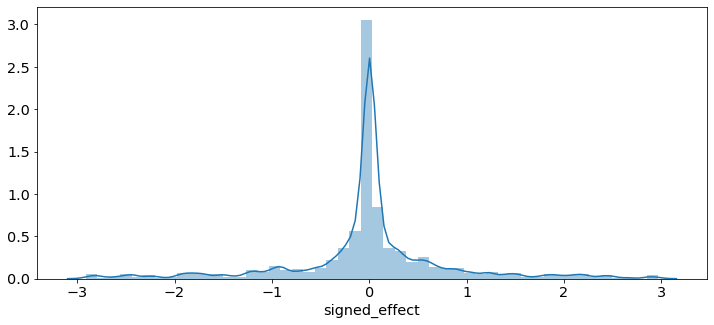

In [40]:
sns.distplot(data.signed_effect)

In [41]:
selected_data = data.copy()
selected_data = selected_data.loc[selected_data.imbalance.between(.02, .25)]

In [42]:
selected_data['residuals'] = np.square(selected_data.signed_effect
                                       - selected_data.signed_effect.mean()) - selected_data.bias
selected_data['square_imbalance'] = np.square(selected_data.imbalance)

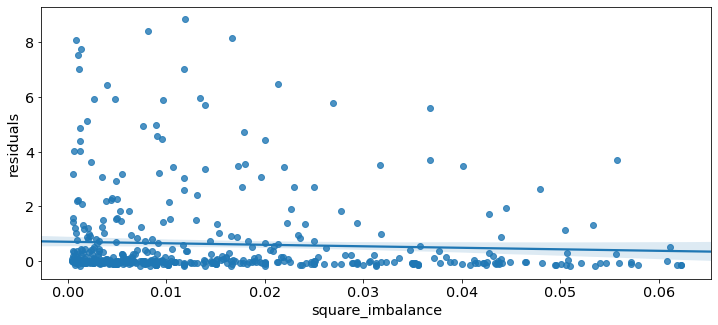

In [43]:
sns.regplot('square_imbalance', 'residuals', selected_data)

In [44]:
import matplotlib.ticker as mtick

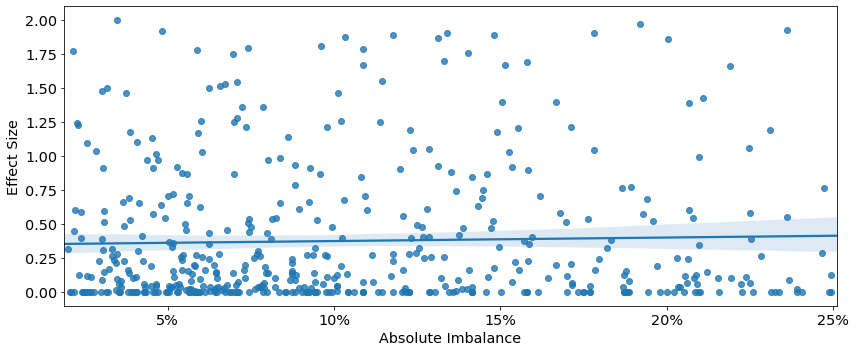

In [45]:
ax = sns.regplot('imbalance', 'effect_size', selected_data.loc[selected_data.effect_size <2])
plt.ylabel('Effect Size')
plt.xlabel('Absolute Imbalance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.xlim(0.019,.251)
plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_effect_size.pdf')
plt.show()

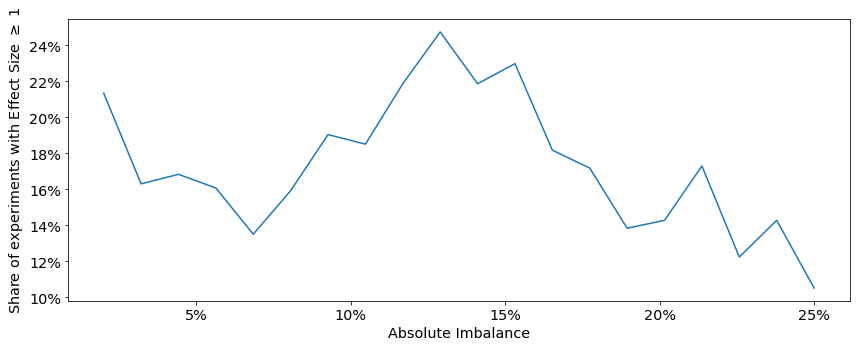

In [46]:
step = .025
share_large_effects = []

for imbalance in np.linspace(.02, .25, 20):
    is_large = (selected_data.loc[selected_data.imbalance.between(imbalance - step, imbalance + step)
                             ].effect_size >= 1)
    share_large_effects.append(is_large.mean())
    std_error = [is_large.std()]
share_large_effects

fig, ax = plt.subplots()
plt.plot(np.linspace(.02, .25, 20), share_large_effects)
plt.xlabel('Absolute Imbalance')
plt.ylabel('Share of experiments with Effect Size $\geq$ 1')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_large_effect_size.pdf')
plt.show()

In [47]:
mod = smf.ols('effect_size ~ imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1896
Date:                Sun, 27 Dec 2020   Prob (F-statistic):              0.663
Time:                        17:39:03   Log-Likelihood:                -533.33
No. Observations:                 520   AIC:                             1071.
Df Residuals:                     518   BIC:                             1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5066      0.059      8.516      0.0

In [48]:
mod = smf.ols('effect_size ~ imbalance + inverse_sample_size' , selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.265
Date:                Sun, 27 Dec 2020   Prob (F-statistic):              0.283
Time:                        17:39:03   Log-Likelihood:                -532.16
No. Observations:                 520   AIC:                             1070.
Df Residuals:                     517   BIC:                             1083.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5330    

In [49]:
mod = smf.ols('residuals ~ square_imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.510
Date:                Sun, 27 Dec 2020   Prob (F-statistic):              0.220
Time:                        17:39:04   Log-Likelihood:                -956.23
No. Observations:                 520   AIC:                             1916.
Df Residuals:                     518   BIC:                             1925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7057      0.092  

In [50]:
mod = smf.ols('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.833
Date:                Sun, 27 Dec 2020   Prob (F-statistic):              0.161
Time:                        17:39:04   Log-Likelihood:                -955.15
No. Observations:                 520   AIC:                             1916.
Df Residuals:                     517   BIC:                             1929.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8079    

In [51]:
mod = smf.quantreg('residuals ~ square_imbalance', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:             0.001499
Model:                       QuantReg   Bandwidth:                      0.2111
Method:                 Least Squares   Sparsity:                       0.4664
Date:                Sun, 27 Dec 2020   No. Observations:                  520
Time:                        17:39:05   Df Residuals:                      518
                                        Df Model:                            1
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0044      0.014      0.312      0.755      -0.023       0.032
square_imbalance    -1.1283      0.686     -1.645      0.101      -2.476       0.219


In [52]:
mod = smf.quantreg('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:              0.01417
Model:                       QuantReg   Bandwidth:                      0.2058
Method:                 Least Squares   Sparsity:                       0.4310
Date:                Sun, 27 Dec 2020   No. Observations:                  520
Time:                        17:39:05   Df Residuals:                      517
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0441      0.016      2.700      0.007       0.012       0.076
square_imbalance     1.364e-05      0.710   1.92e-05      1.000      -1.394       1.394
inverse_sample_size    -5.0171      0.940     -5.339      0.000      -6.863      -3.171
